# Accumulation investment simulation
Excahnge rate is NOT included!!

In [ ]:
nisa_capacity = 18000000
monthly_investment_until_fill_nisa = 100000
monthly_investment_after_fill_nisa = 50000
accumulation_year = 35
trust_fee = 0.2  # percentage per year

monthly_withdrawal_after_retirement = 100000
year_after_retirement = 40

# ticker_symbol = "ACWI"  # All Country World Index
# ticker_symbol = "^GSPC"  # S&P 500
# ticker_symbol = "^N225"  # Nikkei 225
ticker_symbol = "SCHD"  # Schwab US Dividend Equity ETF
# ticker_symbol = "^RUT"  # Russell 2000

monte_carlo_simulation_time = 10000

## Index history and score

In [127]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

index_data = yf.download(ticker_symbol, period="max")
index_data

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,SCHD,SCHD,SCHD,SCHD,SCHD
Date,,,,,
2011-10-20,7.142874,7.162890,7.068528,7.148592,296700
2011-10-21,7.282984,7.282984,7.217217,7.242952,566400
2011-10-24,7.323018,7.431676,7.285844,7.431676,889800
2011-10-25,7.202921,7.297283,7.200062,7.297283,283200
2011-10-26,7.277267,7.308721,7.180046,7.308721,135000
...,...,...,...,...,...
2025-03-19,28.030001,28.100000,27.799999,27.940001,13079400
2025-03-20,27.950001,28.080000,27.860001,27.900000,11317400


In [128]:
# Resample to monthly data and get Open and Close
monthly_index = index_data.resample('ME').agg({('Open', ticker_symbol): 'first', ('Close', ticker_symbol): 'last'})
# Calculate the monthly return
monthly_index['Return'] = monthly_index['Close'].pct_change()
# Drop the first and last row, which is the current month
monthly_index = monthly_index.iloc[1:-1]
# monthly_index.to_csv('monthly_index.csv')
monthly_index

Price,Open,Close,Return
Ticker,SCHD,SCHD,
Date,,,
2011-11-30,7.205781,7.411661,0.016471
2011-12-31,7.440253,7.486004,0.010031
2012-01-31,7.597523,7.608960,0.016425
2012-02-29,7.654711,7.826278,0.028561
2012-03-31,7.849154,7.974967,0.018999
...,...,...,...
2024-10-31,27.919619,27.969156,0.001893
2024-11-30,28.038510,29.257147,0.046050


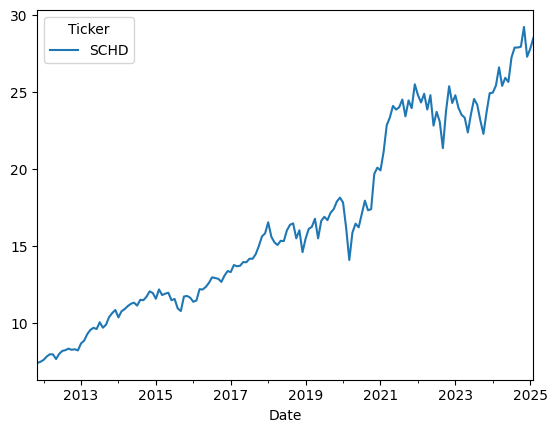

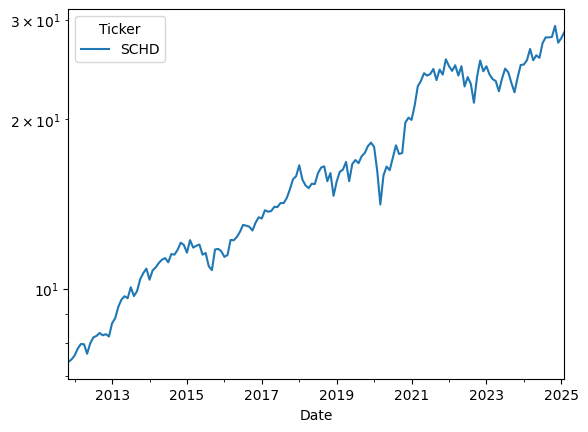

mean:  0.009336686494269669
std:  0.03943203924513267


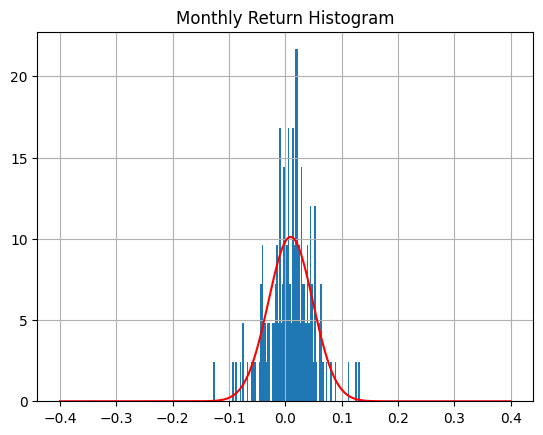

In [129]:
# Visualize the monthly index chart
monthly_index['Close'].plot()
plt.show()
monthly_index['Close'].plot(logy=True)
plt.show()

# Calculate the mean and standard deviation of the monthly return
mean_monthly_return = monthly_index['Return'].mean()
std_monthly_return = monthly_index['Return'].std()
print("mean: ", mean_monthly_return)
print("std: ", std_monthly_return)

# Visualize the monthly return histogram
monthly_index['Return'].hist(bins=100, density=True)
# Overlay the normal distribution according to the mean and standard deviation
x = np.linspace(-0.4, 0.4, 1000)
y = 1 / (std_monthly_return * np.sqrt(2 * np.pi)) * np.exp(- (x - mean_monthly_return) ** 2 / (2 * std_monthly_return ** 2))
plt.plot(x, y, color='r')
plt.title('Monthly Return Histogram')
plt.show()


## Monte Carlo simulation until retirement

In [130]:
import math
# monthly_trust_fee = math.pow((trust_fee / 100), (1/12))
monthly_trust_fee = trust_fee / 100 / 12
print("Monthly Trust Fee: ", monthly_trust_fee)
result = []
for n in range(monte_carlo_simulation_time):
    accumulated_principal = 0
    market_value = 0
    investment_return = 0
    for year in range(accumulation_year):
        for month in range(12):
            if accumulated_principal < nisa_capacity:
                accumulated_principal += monthly_investment_until_fill_nisa
                market_value += monthly_investment_until_fill_nisa
                investment_return += monthly_investment_until_fill_nisa
            else:
                accumulated_principal += monthly_investment_after_fill_nisa
                market_value += monthly_investment_after_fill_nisa
                investment_return += monthly_investment_after_fill_nisa

            market_value *= (1 + np.random.normal(mean_monthly_return, std_monthly_return))
            investment_return *= (1 + np.random.normal(mean_monthly_return, std_monthly_return) - monthly_trust_fee)
            
    result.append(investment_return)
result = pd.Series(result)
# print(result.mean())
# print(result.std())
print("Principal: ", accumulated_principal)
print("========================================")
print("Worst case: ", int(result.min()))
print("Bottom 1%: ", int(result.quantile(0.01)))
print("Bottom 2%: ", int(result.quantile(0.02)))
print("Bottom 3%: ", int(result.quantile(0.03)))
print("Bottom 4%: ", int(result.quantile(0.04)))
print("Bottom 5%: ", int(result.quantile(0.05)))
print("Bottom 10%: ", int(result.quantile(0.1)))
print("Bottom 20%: ", int(result.quantile(0.2)))
print("Bottom 30%: ", int(result.quantile(0.3)))
print("Median: ", int(result.quantile(0.5)))
print("Top 10%: ", int(result.quantile(0.9)))

Monthly Trust Fee:  8.333333333333333e-05
Principal:  30000000
Worst case:  29855604
Bottom 1%:  84786440
Bottom 2%:  97442629
Bottom 3%:  110966521
Bottom 4%:  120639371
Bottom 5%:  129327784
Bottom 10%:  160001436
Bottom 20%:  213276817
Bottom 30%:  263253594
Median:  374030025
Top 10%:  888844538


## Monte Carlo simulation lifetime

In [131]:
monthly_trust_fee = trust_fee / 100 / 12
result = []
for n in range(monte_carlo_simulation_time):
    accumulated_principal = 0
    market_value = 0
    investment_return = 0
    for year in range(accumulation_year):
        for month in range(12):
            if accumulated_principal < nisa_capacity:
                accumulated_principal += monthly_investment_until_fill_nisa
                market_value += monthly_investment_until_fill_nisa
                investment_return += monthly_investment_until_fill_nisa
            else:
                accumulated_principal += monthly_investment_after_fill_nisa
                market_value += monthly_investment_after_fill_nisa
                investment_return += monthly_investment_after_fill_nisa

            market_value *= (1 + np.random.normal(mean_monthly_return, std_monthly_return))
            investment_return *= (1 + np.random.normal(mean_monthly_return, std_monthly_return) - monthly_trust_fee)

    total_withdrawal = 0        
    for year in range(year_after_retirement):
        for month in range(12):
            total_withdrawal -= monthly_withdrawal_after_retirement
            market_value -= monthly_withdrawal_after_retirement
            investment_return -= monthly_withdrawal_after_retirement
            if market_value > 0:
                market_value *= (1 + np.random.normal(mean_monthly_return, std_monthly_return))
                investment_return *= (1 + np.random.normal(mean_monthly_return, std_monthly_return) - monthly_trust_fee)
            else:
                # Bankrupt
                market_value = market_value
                investment_return = investment_return

    result.append(investment_return)
result = pd.Series(result)
# print(result.mean())
# print(result.std())
print("Principal: ", accumulated_principal)
print("total_withdrawal: ", total_withdrawal)
print("========================================")
print("Worst case: ", int(result.min()))
print("Bottom 1%: ", int(result.quantile(0.01)))
print("Bottom 2%: ", int(result.quantile(0.02)))
print("Bottom 3%: ", int(result.quantile(0.03)))
print("Bottom 4%: ", int(result.quantile(0.04)))
print("Bottom 5%: ", int(result.quantile(0.05)))
print("Bottom 10%: ", int(result.quantile(0.1)))
print("Bottom 20%: ", int(result.quantile(0.2)))
print("Bottom 30%: ", int(result.quantile(0.3)))
print("Median: ", int(result.quantile(0.5)))
print("Top 10%: ", int(result.quantile(0.9)))

Principal:  30000000
total_withdrawal:  -48000000
Worst case:  252251800
Bottom 1%:  1411272476
Bottom 2%:  1992615820
Bottom 3%:  2380336367
Bottom 4%:  2756972727
Bottom 5%:  3161611365
Bottom 10%:  5063416745
Bottom 20%:  8354089669
Bottom 30%:  11745229110
Median:  20955164220
Top 10%:  87780063918


## Monte Carlo simulation only after retirement

In [132]:
initial_capital = 50000000

monthly_trust_fee = trust_fee / 100 / 12

result = []
for n in range(monte_carlo_simulation_time):
    accumulated_principal = initial_capital
    market_value = initial_capital
    investment_return = initial_capital

    total_withdrawal = 0        
    for year in range(year_after_retirement):
        for month in range(12):
            total_withdrawal -= monthly_withdrawal_after_retirement
            market_value -= monthly_withdrawal_after_retirement
            if market_value > 0:
                market_value *= (1 + np.random.normal(mean_monthly_return, std_monthly_return))
                investment_return *= (1 + np.random.normal(mean_monthly_return, std_monthly_return) - monthly_trust_fee)
            else:
                # Bankrupt
                market_value = market_value

    result.append(investment_return)
result = pd.Series(result)
# print(result.mean())
# print(result.std())
print("Principal: ", accumulated_principal)
print("total_withdrawal: ", total_withdrawal)
print("========================================")
print("Worst case: ", int(result.min()))
print("Bottom 1%: ", int(result.quantile(0.01)))
print("Bottom 2%: ", int(result.quantile(0.02)))
print("Bottom 3%: ", int(result.quantile(0.03)))
print("Bottom 4%: ", int(result.quantile(0.04)))
print("Bottom 5%: ", int(result.quantile(0.05)))
print("Bottom 10%: ", int(result.quantile(0.1)))
print("Bottom 20%: ", int(result.quantile(0.2)))
print("Bottom 30%: ", int(result.quantile(0.3)))
print("Median: ", int(result.quantile(0.5)))
print("Top 10%: ", int(result.quantile(0.9)))

Principal:  50000000
total_withdrawal:  -48000000
Worst case:  158622433
Bottom 1%:  385419410
Bottom 2%:  487021806
Bottom 3%:  558984425
Bottom 4%:  626461071
Bottom 5%:  686001756
Bottom 10%:  949707955
Bottom 20%:  1398560925
Bottom 30%:  1838440873
Median:  2889677140
Top 10%:  8660116988
